--2017-11-29 23:01:10--  https://raw.githubusercontent.com/brandomr/document_cluster/master/synopses_list_imdb.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839682 (820K) [text/plain]
Saving to: ‘synopses_list_imdb.txt’

synopses_list_imdb. 100%[===================>] 820.00K  5.05MB/s    in 0.2s    

2017-11-29 23:01:10 (5.05 MB/s) - ‘synopses_list_imdb.txt’ saved [839682/839682]



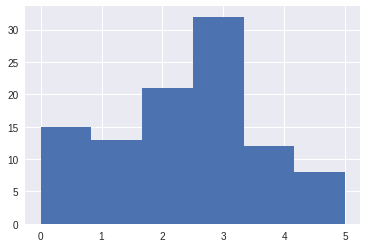

Top terms per cluster:
Cluster 0:  father  marri  love  war  life
Cluster 1:  polic  ask  look  tri  mother
Cluster 2:  kill  order  men  offic  attack
Cluster 3:  love  return  live  come  life
Cluster 4:  say  ask  talk  goe  get
Cluster 5:  famili  war  kill  father  play


In [5]:
!rm synopses_list_imdb.txt
!wget https://raw.githubusercontent.com/brandomr/document_cluster/master/synopses_list_imdb.txt

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk
import re
import nltk.stem

class StemmedTfidfVectorizer(TfidfVectorizer): # hérite de TfidVectorizer
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))
     
    
    
stemmer=nltk.stem.SnowballStemmer('english')
  
synopses = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')


synopses_clean = []
for text in synopses:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean.append(text)
    
stemmer=nltk.stem.SnowballStemmer('english')

vectorizer = StemmedTfidfVectorizer(max_df=0.7, min_df=0.3,  ngram_range=(1,3), stop_words='english')
X = vectorizer.fit_transform(synopses)
 
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=20, n_init=1)
model.fit(X)



plt.hist(model.labels_, bins=true_k)
plt.show()
cluster_names=[]

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    names=[]
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind]),
        names.append(terms[ind])
    cluster_names.append(names)
    print
    



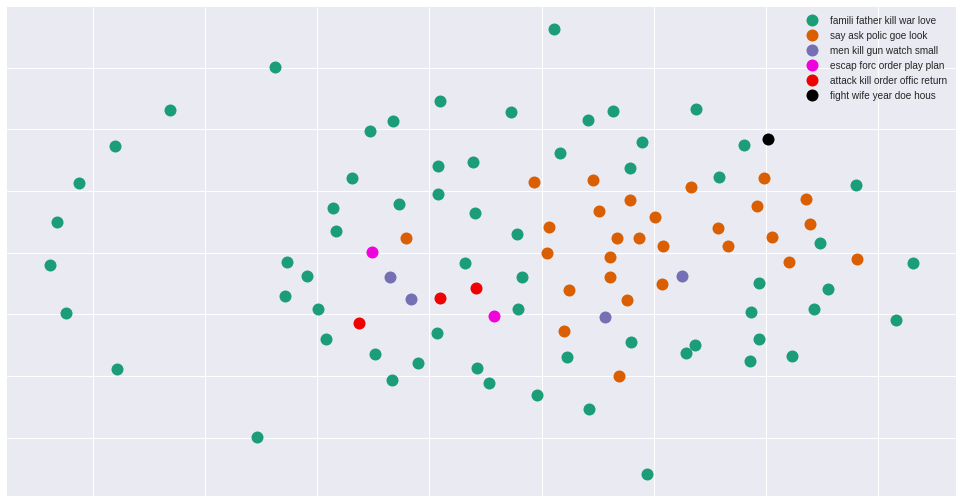

In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS


dist = 1 - cosine_similarity(X)


MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#ef02db', 4:'#ef0202', 5:'#000000'}

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

clusters = model.labels_.tolist()
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=' '.join(cluster_names[name]), color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], "", size=8)  
